In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!unzip "drive/My Drive/star_wars.zip" 

Archive:  drive/My Drive/star_wars.zip
   creating: star_wars/chewbacca/
  inflating: star_wars/chewbacca/pic_001.jpg  
  inflating: star_wars/chewbacca/pic_002.jpg  
  inflating: star_wars/chewbacca/pic_003.jpg  
  inflating: star_wars/chewbacca/pic_004.jpg  
  inflating: star_wars/chewbacca/pic_005.jpg  
  inflating: star_wars/chewbacca/pic_006.jpg  
  inflating: star_wars/chewbacca/pic_007.jpg  
  inflating: star_wars/chewbacca/pic_008.jpg  
  inflating: star_wars/chewbacca/pic_009.jpg  
  inflating: star_wars/chewbacca/pic_010.jpg  
  inflating: star_wars/chewbacca/pic_011.jpg  
  inflating: star_wars/chewbacca/pic_012.jpg  
  inflating: star_wars/chewbacca/pic_013.jpg  
  inflating: star_wars/chewbacca/pic_014.jpg  
  inflating: star_wars/chewbacca/pic_015.jpg  
  inflating: star_wars/chewbacca/pic_016.jpg  
  inflating: star_wars/chewbacca/pic_017.jpg  
  inflating: star_wars/chewbacca/pic_018.jpg  
  inflating: star_wars/chewbacca/pic_019.jpg  
  inflating: star_wars/chewbacca/p

In [4]:
import numpy as np
import torch
import os
import cv2
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet34
from google.colab import auth
from googleapiclient.discovery import build
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from skimage import color
import random

In [5]:
# def download_data(file_id, file_name):
#   import io
#   from googleapiclient.http import MediaIoBaseDownload

#   request = drive_service.files().get_media(fileId=file_id)
#   downloaded = io.BytesIO()
#   downloader = MediaIoBaseDownload(downloaded, request)
#   done = False
#   while done is False:
#     _, done = downloader.next_chunk()
    
#   downloaded.seek(0)
#   with open(file_name, "wb") as f:
#     f.write(downloaded.read())

  
# auth.authenticate_user()
# drive_service = build('drive', 'v3')

# file_id = '139wA_Z9kustXy54ifhWWHJvARo5f7O6y'
# file_name = 'star_wars.tar.gz'

# download_data(file_id, file_name)
# !tar xf star_wars.tar.gz

In [6]:
file_names = []
file_labels = []
for idx, class_dir in enumerate(os.listdir("star_wars")):
  print(f"берем файлы из папки \"{class_dir}\" и даем им класс {idx}")
  
  # не берем файлы кроме .jpg .jpeg и .png
  for file in os.listdir(os.path.join("star_wars", class_dir)):
    if not file.endswith(('.jpg', '.jpeg', '.png')):
      continue
      
    file_names.append(os.path.join("star_wars", class_dir, file))
    file_labels.append(idx)

берем файлы из папки "chewbacca" и даем им класс 0
берем файлы из папки "princess_leia" и даем им класс 1
берем файлы из папки "darth_vader" и даем им класс 2
берем файлы из папки "luke_skywalker" и даем им класс 3


Это типичная ситуация, как у вас могут оказаться данные на руках

1


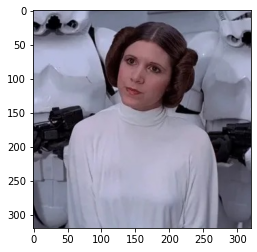

In [7]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray  

# будем брать по 1 рандомной картинке, выводить ее и смотреть на класс.
random_index = np.random.choice(range(len(file_names)))
test_img = cv2.imread(file_names[random_index])[:, :, ::-1] # эта штука в конце равносильно переводу из BGR в RGB
print(file_labels[random_index])
plt.imshow(test_img)


(320, 320, 3)

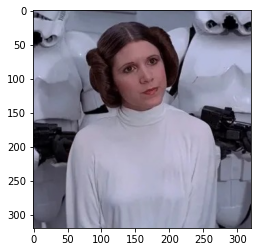

In [8]:
#Отражение
horizontal_img = cv2.flip(test_img, 1)
plt.imshow(horizontal_img)
horizontal_img.shape

(320, 320, 3)

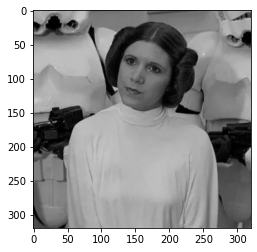

In [9]:
#Перевод в серый
test_img = rgb2gray(cv2.imread(file_names[random_index])[:, :, ::-1]) # эта штука в конце равносильно переводу из BGR в RGB

test_img = np.array([[[s,s,s] for s in r] for r in test_img],dtype="u1")

plt.imshow(test_img)
test_img.shape

In [10]:
# Задание 1. Разбейте filenames и labels на train и test части 70/30
train_file_names, test_file_names, train_file_labels, test_file_labels = train_test_split(file_names, file_labels, test_size = 0.3, train_size = 0.7)

print(len(file_names), len(file_labels))
len(train_file_names), len(train_file_labels), len(test_file_names), len(test_file_labels)

4434 4434


(3103, 3103, 1331, 1331)

In [11]:
def add_pad(img, shape):
    color_pick = img[0][0]
    padded_img = color_pick * np.ones(shape + img.shape[2:3], dtype=np.uint8)
    x_offset = int((padded_img.shape[0] - img.shape[0]) / 2)
    y_offset = int((padded_img.shape[1] - img.shape[1]) / 2)
    padded_img[x_offset:x_offset + img.shape[0], y_offset:y_offset + img.shape[1]] = img

    return padded_img


def resize(img, shape):
    scale = min(shape[0] * 1.0 / img.shape[0], shape[1] * 1.0 / img.shape[1])
    if scale != 1:
        img = cv2.resize(img, dsize=None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    return img


def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray    

In [12]:
Реализация класса-наследника Dataset. Он должен возвращать по индексу 
class StarWarsDataset(Dataset):
    def __init__(self, filenames, labels):
        self.filenames = filenames
        self.labels = labels

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx, p=15):
        filename = self.filenames[idx]
        label = self.labels[idx]
        
        if random.randint(1,100) < p:
            img = rgb2gray(cv2.imread(filename)[:, :, ::-1])
            img = np.array([[[s,s,s] for s in r] for r in img],dtype="u1")
        else:
            img = cv2.imread(filename)[:, :, ::-1]

        if random.randint(1,100) < 5:
            img = cv2.GaussianBlur(img, (15, 15), 0)

        if random.randint(1,100) < p:
            img = cv2.flip(img, 1)
         
        img = resize(img, (224, 224))
        img = add_pad(img, (224, 224))
        
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1) / 255.

        return img, label

In [13]:
 
 class StarWarsDataset_orig(Dataset):
    def __init__(self, filenames, labels):
        self.filenames = filenames
        self.labels = labels

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        label = self.labels[idx]
      
        img = cv2.imread(filename)[:, :, ::-1]
             
        img = resize(img, (224, 224))
        img = add_pad(img, (224, 224))
       
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1) / 255.      

        return img, label

Мы написали типичный класс-наследник Dataset для данных такого формата и поресайзили изображение к размеру 224х224 + преобразовали его в тензор внутри него. Теперь нужно создать Dataloader - да штука, которая просит возвращать Dataset данные по idx и составляет их них батчи.

In [14]:
train_dataset = StarWarsDataset(train_file_names, train_file_labels)
train_dataloder = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=0)

test_dataset = StarWarsDataset_orig(test_file_names, test_file_labels)
test_dataloder = DataLoader(test_dataset, shuffle=False, batch_size=64, num_workers=0)

Что выводит Dataloader...

In [15]:
for batch in test_dataloder: # получаем 1 batch - 1 итерация подгрузки данных
  images, labels = batch     # наш Dataset возвращает tuple, поэтому мы можем сделать так
  print(f'Всего батчей по batch_size: {len(test_dataloder)}')
  print(f'Лейбл первого элемента в первом батче: {labels[0]}')
  print(f'Размер картинки в первом батче: {images[0].shape}')
  print(f'Картинка в первом батче: {images[0]}')
  break

Всего батчей по batch_size: 21
Лейбл первого элемента в первом батче: 2
Размер картинки в первом батче: torch.Size([3, 224, 224])
Картинка в первом батче: tensor([[[0.2510, 0.2510, 0.2510,  ..., 0.2510, 0.2510, 0.2510],
         [0.2510, 0.2510, 0.2510,  ..., 0.2510, 0.2510, 0.2510],
         [0.2510, 0.2510, 0.2510,  ..., 0.2510, 0.2510, 0.2510],
         ...,
         [0.2510, 0.2510, 0.2510,  ..., 0.2510, 0.2510, 0.2510],
         [0.2510, 0.2510, 0.2510,  ..., 0.2510, 0.2510, 0.2510],
         [0.2510, 0.2510, 0.2510,  ..., 0.2510, 0.2510, 0.2510]],

        [[0.2510, 0.2510, 0.2510,  ..., 0.2510, 0.2510, 0.2510],
         [0.2510, 0.2510, 0.2510,  ..., 0.2510, 0.2510, 0.2510],
         [0.2510, 0.2510, 0.2510,  ..., 0.2510, 0.2510, 0.2510],
         ...,
         [0.2510, 0.2510, 0.2510,  ..., 0.2510, 0.2510, 0.2510],
         [0.2510, 0.2510, 0.2510,  ..., 0.2510, 0.2510, 0.2510],
         [0.2510, 0.2510, 0.2510,  ..., 0.2510, 0.2510, 0.2510]],

        [[0.2667, 0.2667, 0.2667,

In [16]:
# Здесь мы берем предобученный resnet34 и заменяем в нём последний слой на голову классифицирующую изображение на 1 из 4 классов
# Мы замораживаем все слои сети кроме последнего, который будем обучать далее

model = resnet34(pretrained=True) # resnet обученный на ImageNet
for param in model.parameters():
  param.requires_grad=False

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [17]:
# можно принтануть модель и уведеть какие в ней слои
#print(model)

В resnet куча сверток и пулингов, в конце fully connected слой на 1000. Мы удаляет последний слой, заменяя его новым на с выходом на 4 класса. Так, свертки внутри модели помнят все фичи умеют распознавать классы из ImageNet, мы просто помогаем их скорректировать на наших данных  

In [18]:
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 4)
model.to('cuda')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
# Берём кросс энтропию в качестве лосса и оптимизатор адам
# loss и optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [20]:
from tqdm.notebook import tqdm

In [21]:
#Эта функция считает точность модели - на вход передается сама модель, номер эпохи и тестовый лоадер.

def run_test_on_epoch(model, epoch, test_loader):
    model.eval()
    with torch.no_grad():
      test_accuracy = []
      test_real = []
      for batch_x, batch_y in tqdm(test_loader):
          outputs = model(batch_x.to('cuda')).detach().cpu().numpy()
          test_accuracy.append(outputs)
          test_real.append(batch_y.detach().cpu().numpy())     
      print("Epoch", epoch, "test accuracy", accuracy_score(np.hstack(test_real), np.argmax(np.vstack(test_accuracy), axis=1)))
       
    model.train()
   

In [22]:
# Задание 5. Напишите код для обучения модели 25 эпох. В конце каждой эпохи вызывайте run_test_on_epoch() чтобы следить за точностью
for epoch in tqdm(range(25)):
  for image, label in train_dataloder:
    optimizer.zero_grad()
    output = model(image.to('cuda'))
    loss = criterion(output, label.to('cuda'))
    loss.backward()
    optimizer.step()
  run_test_on_epoch(model, epoch, test_dataloder)
       


Epoch 0 test accuracy 0.8564988730277987



Epoch 1 test accuracy 0.9113448534936138



Epoch 2 test accuracy 0.9361382419233659



Epoch 3 test accuracy 0.9444027047332832



Epoch 4 test accuracy 0.9451540195341849



Epoch 5 test accuracy 0.9504132231404959



Epoch 6 test accuracy 0.9504132231404959



Epoch 7 test accuracy 0.9556724267468069



Epoch 8 test accuracy 0.9549211119459053



Epoch 9 test accuracy 0.9571750563486101



Epoch 10 test accuracy 0.9601803155522164



Epoch 11 test accuracy 0.9594290007513148



Epoch 12 test accuracy 0.9601803155522164



Epoch 13 test accuracy 0.9631855747558227



Epoch 14 test accuracy 0.9624342599549212



Epoch 15 test accuracy 0.9594290007513148



Epoch 16 test accuracy 0.9594290007513148



Epoch 17 test accuracy 0.9609316303531179



Epoch 18 test accuracy 0.9624342599549212



Epoch 19 test accuracy 0.9616829451540195



Epoch 20 test accuracy 0.966190833959429



Epoch 21 test accuracy 0.9609316303531179



Epoch 22 test accuracy 0.9631855747558227



Epoch 23 test accuracy 0.9609316303531179



Epoch 24 test accuracy 0.9616829451540195

